## Final validation

In [1]:
import multirex as mrex
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import pandas as pd
from tqdm import tqdm
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning, UndefinedMetricWarning

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import hamming_loss, accuracy_score


## import models

In [2]:
import joblib
## load rf per molecule
SC_rf_CH4 = joblib.load("CH4_rf.joblib")
SC_rf_O3 = joblib.load("O3_rf.joblib")
SC_rf_H2O = joblib.load("H2O_rf.joblib")

MC_rf = joblib.load("MC_rf.joblib")

BC_rf = joblib.load("BC_rf.joblib")


In [3]:
def normalize_min_max_by_row(df):
    min_by_row = df.min(axis=1)
    max_by_row = df.max(axis=1)
    
    range_by_row = max_by_row - min_by_row
    normalized = (df.sub(min_by_row, axis=0)).div(range_by_row, axis=0)
    return normalized

import ast
def string_to_list(string):
    return ast.literal_eval(string)

def remove_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=DataConversionWarning)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    warnings.filterwarnings("ignore", category=UserWarning)

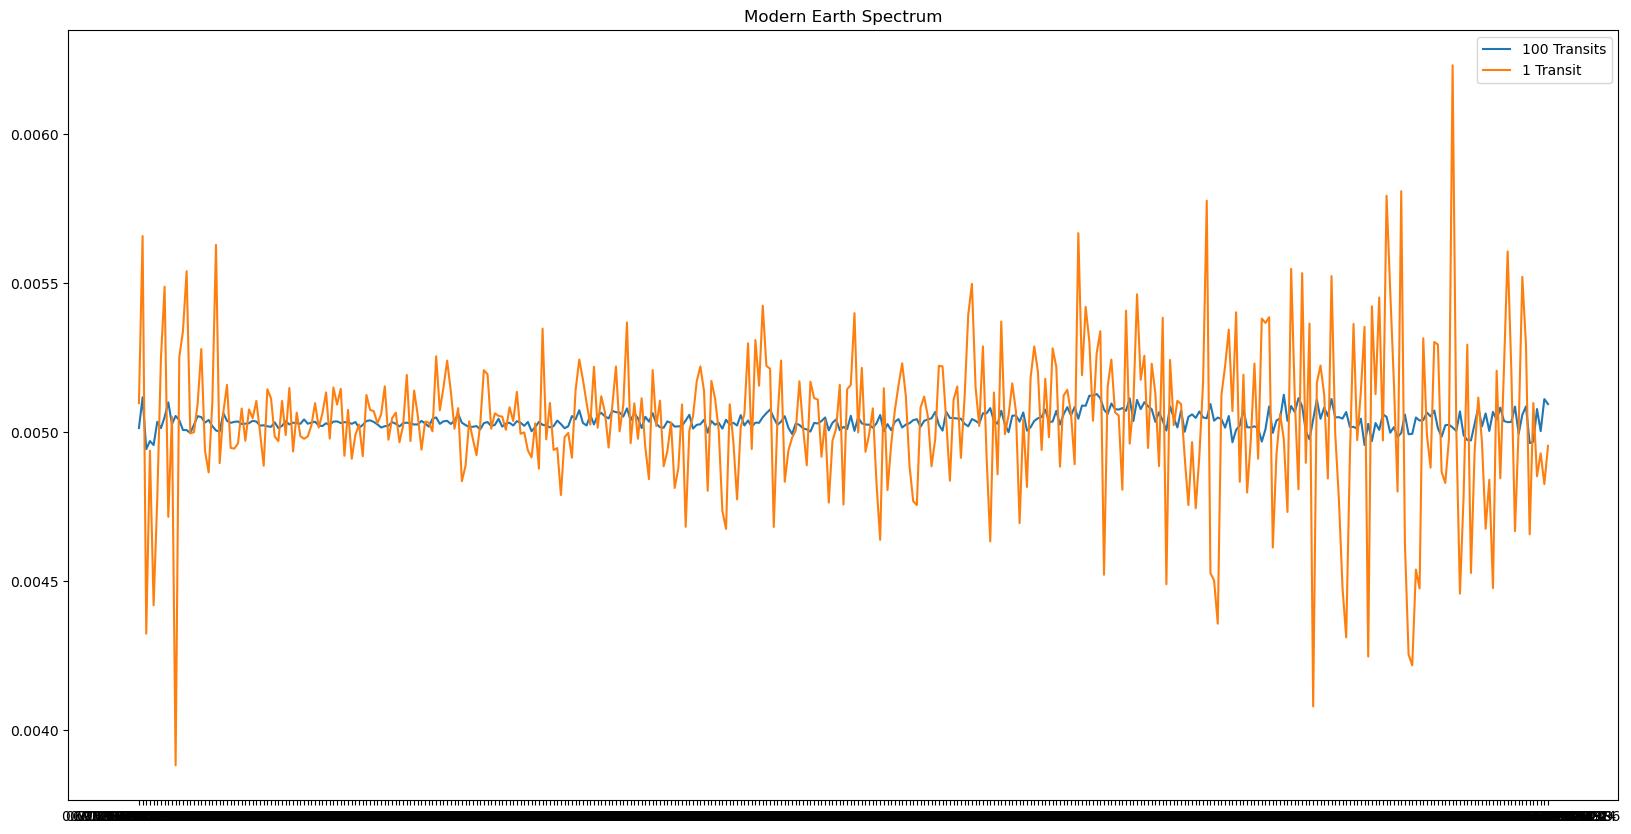

In [4]:
plt.figure(figsize=(20, 10)) 
plt.plot(pd.read_csv("spec_earth/E_0.0Ga_100_Transits.csv").iloc[0], label="100 Transits")
plt.plot(pd.read_csv("spec_earth/E_0.0Ga_1_Transits.csv").iloc[0], label="1 Transit")
plt.title("Modern Earth Spectrum")
plt.legend()


# Test



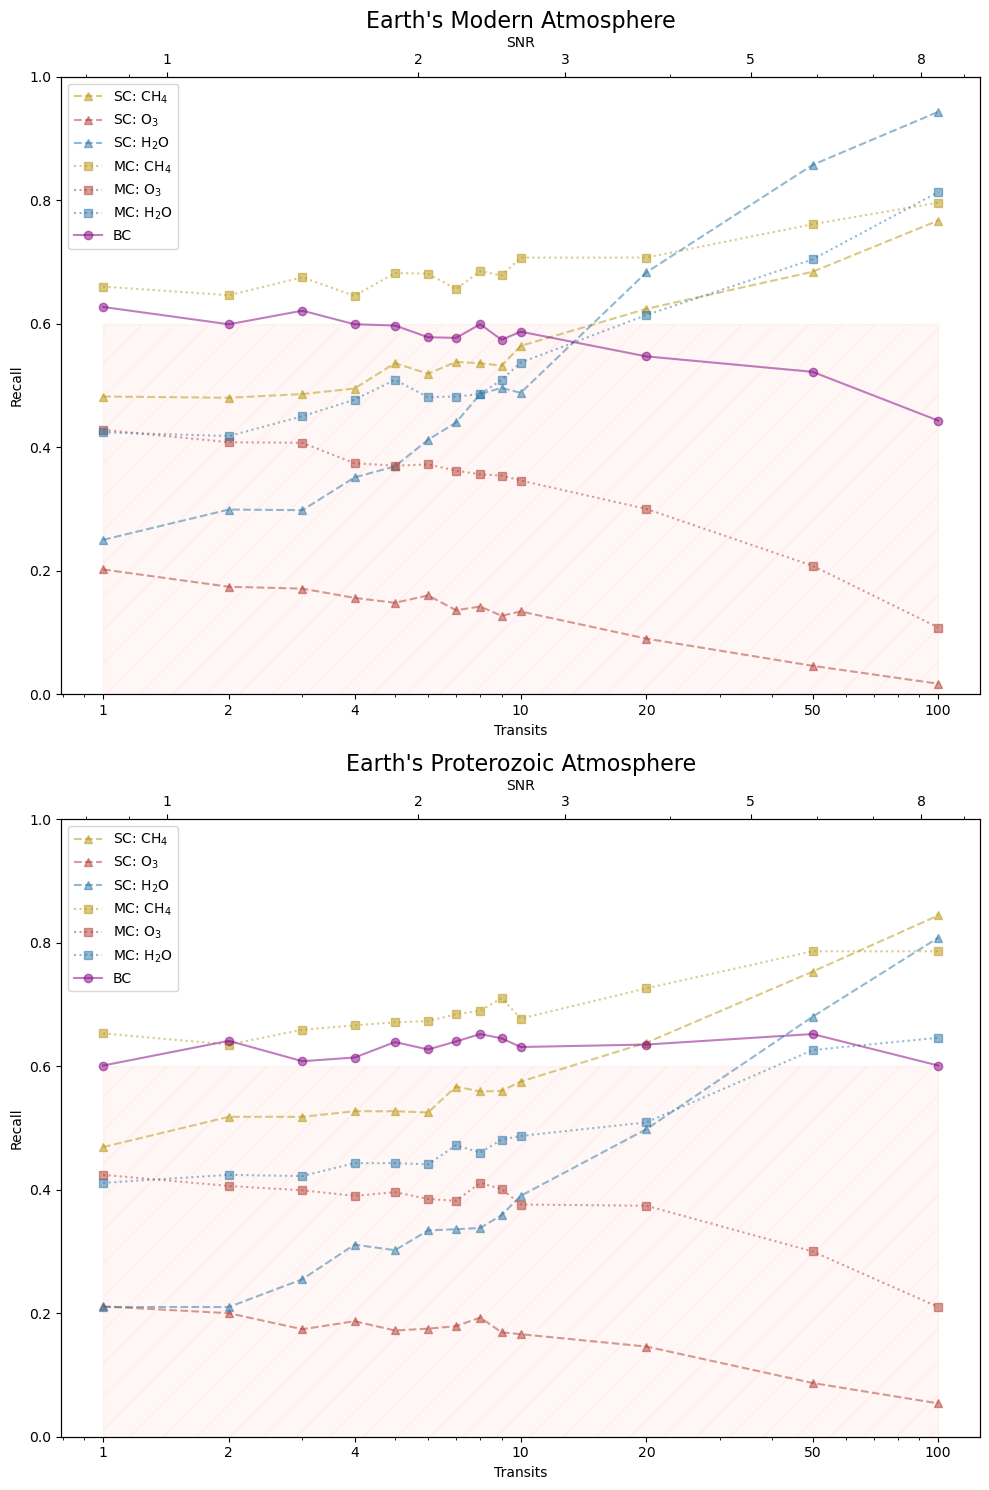

In [5]:
##------- MODERN EARTH -------##

SC_scores = dict(
    SNR=[],
    f1= [ [] , [] , [] ],
    recall_score = [ [] , [] , [] ],
    precision_score= [ [] , [] , [] ],
    accuracy= [ [] , [] , [] ],
    min_mix_ratio= [ [] , [] , [] ],
    TNR = [ [] , [] , [] ], 
) 


MC_scores = dict(
    SNR=[],
    f1= [ [] , [] , [] ],
    recall_score = [ [] , [] , [] ],
    precision_score= [ [] , [] , [] ],
    accuracy= [ [] , [] , [] ],
    min_mix_ratio= [ [] , [] , [] ],
    TNR = [ [] , [] , [] ], 
) 

BC_recall = []

n_transits= [1,2,3,4,5,6,7,8,9,10,20,50,100
             ]

## Taken from the JWST analysis with SNR vs N_transits
## SNR [1:100]
JWST = [0.83862624, 1.1859966 , 1.45254326, 1.67725248, 1.87522528,
       2.05420638, 2.21879648, 2.37199321, 2.51587872, 2.65196903,
       2.78140858, 2.90508652, 3.02370991, 3.13785207, 3.24798547,
       3.35450497, 3.45774457, 3.55798981, 3.65548704, 3.75045057,
       3.84306823, 3.93350574, 4.02191017, 4.10841275, 4.19313121,
       4.27617157, 4.35762978, 4.43759296, 4.51614052, 4.5933451 ,
       4.6692733 , 4.74398642, 4.81754098, 4.88998927, 4.96137975,
       5.03175745, 5.10116428, 5.16963935, 5.2372192 , 5.30393806,
       5.36982801, 5.43491921, 5.49924002, 5.56281717, 5.62567585,
       5.6878399 , 5.74933185, 5.81017304, 5.87038369, 5.92998302,
       5.98898928, 6.04741983, 6.10529119, 6.16261913, 6.21941866,
       6.27570414, 6.33148928, 6.38678718, 6.44161039, 6.49597093,
       6.54988033, 6.60334963, 6.65638943, 6.70900993, 6.76122091,
       6.81303179, 6.86445163, 6.91548915, 6.96615275, 7.01645054,
       7.06639032, 7.11597963, 7.16522575, 7.21413571, 7.26271629,
       7.31097408, 7.3589154 , 7.40654642, 7.45387308, 7.50090114,
       7.54763617, 7.5940836 , 7.64024867, 7.68613646, 7.73175192,
       7.77709982, 7.82218484, 7.86701148, 7.91158414, 7.95590709,
       7.99998447, 8.04382033, 8.08741859, 8.13078308, 8.17391751,
       8.21682551, 8.2595106 , 8.30197623, 8.34422575, 8.38626242]


for i, n_transit in enumerate(n_transits):
    n_transit
    SNR_test_df = pd.read_csv(f"spec_earth/E_0.0Ga_{n_transit}_transits.csv")
    ## add column label and move to the first column
    SNR_test_df['label'] = 1
    SNR_test_df['label'] = SNR_test_df['label'].apply(lambda x: [1,1,1])
    cols = list(SNR_test_df.columns)
    cols = [cols[-1]] + cols[:-1]
    SNR_test_df = SNR_test_df[cols]
    
    ## normalize
    SNR_test_df.iloc[:,1:] = normalize_min_max_by_row(SNR_test_df.iloc[:,1:])
    SNR_X_test = SNR_test_df.iloc[:,1:]
    SNR_X_test = SNR_X_test.values
    SNR_test_CH4 = np.array([item[0] for item in SNR_test_df["label"]]) 
    SNR_test_O3 = np.array([item[1] for item in SNR_test_df["label"]])
    SNR_test_H2O = np.array([item[2] for item in SNR_test_df["label"]])

    SNR_test_df["CH4 label"] = SNR_test_CH4
    SNR_test_df["O3 label"] = SNR_test_O3
    SNR_test_df["H2O label"] = SNR_test_H2O

    remove_warnings()
    
    ### ----------- SC --------------- ###    
    CH4_probabilities= SC_rf_CH4.predict_proba(SNR_X_test)[:,1]
    O3_probabilities= SC_rf_O3.predict_proba(SNR_X_test)[:,1]
    H2O_probabilities= SC_rf_H2O.predict_proba(SNR_X_test)[:,1]
    
    CH4_threshold = 0.4
    O3_threshold = 0.33
    H2O_threshold = 0.36
    
    CH4_y_pred = (CH4_probabilities > CH4_threshold).astype(int)
    O3_y_pred = (O3_probabilities > O3_threshold).astype(int)
    H2O_y_pred = (H2O_probabilities > H2O_threshold).astype(int)
    
    SNR_test_df["CH4 3F pred"] = CH4_y_pred
    SNR_test_df["CH4 score"] = CH4_probabilities
    SNR_test_df["O3 3F pred"] = O3_y_pred
    SNR_test_df["O3 score"] = O3_probabilities
    SNR_test_df["H2O 3F pred"] = H2O_y_pred
    SNR_test_df["H2O score"] = H2O_probabilities
       
    ## mol scores
    SC_scores["SNR"].append(n_transit)
    SC_scores["f1"][0].append(f1_score(
            SNR_test_df["CH4 label"],
            SNR_test_df["CH4 3F pred"]
            ))
    SC_scores["f1"][1].append(f1_score(
            SNR_test_df["O3 label"],
            SNR_test_df["O3 3F pred"]
            ))
    SC_scores["f1"][2].append(f1_score(
            SNR_test_df["H2O label"],
            SNR_test_df["H2O 3F pred"]
            ))
    
    SC_scores["recall_score"][0].append(recall_score(
        SNR_test_df["CH4 label"],
        SNR_test_df["CH4 3F pred"]
        ))
    SC_scores["recall_score"][1].append(recall_score(
        SNR_test_df["O3 label"],
        SNR_test_df["O3 3F pred"]
        ))
    SC_scores["recall_score"][2].append(recall_score(
        SNR_test_df["H2O label"],
        SNR_test_df["H2O 3F pred"]
        ))
    
    SC_scores["precision_score"][0].append(precision_score(
        SNR_test_df["CH4 label"],
        SNR_test_df["CH4 3F pred"]
        ))
    SC_scores["precision_score"][1].append(precision_score(
        SNR_test_df["O3 label"],
        SNR_test_df["O3 3F pred"]
        ))
    SC_scores["precision_score"][2].append(precision_score(
        SNR_test_df["H2O label"],
        SNR_test_df["H2O 3F pred"]
        ))
    
    SC_scores["accuracy"][0].append(accuracy_score(
        SNR_test_df["CH4 label"],
        SNR_test_df["CH4 3F pred"]
        ))
    SC_scores["accuracy"][1].append(accuracy_score(
        SNR_test_df["O3 label"],
        SNR_test_df["O3 3F pred"]
        ))
    SC_scores["accuracy"][2].append(accuracy_score(
        SNR_test_df["H2O label"],
        SNR_test_df["H2O 3F pred"]
        ))
    
    SC_scores["TNR"][0].append(recall_score(
        SNR_test_df["CH4 label"],
        SNR_test_df["CH4 3F pred"], 
        pos_label=0
        ))
    SC_scores["TNR"][1].append(recall_score(
        SNR_test_df["O3 label"],
        SNR_test_df["O3 3F pred"],
        pos_label=0
        ))
    SC_scores["TNR"][2].append(recall_score(
        SNR_test_df["H2O label"],
        SNR_test_df["H2O 3F pred"],
        pos_label=0
        ))
    
    ### ----------- MC --------------- ###

    CH4_probabilities = MC_rf.predict_proba(SNR_X_test)[0][:,1]
    O3_probabilities = MC_rf.predict_proba(SNR_X_test)[1][:,1]
    H2O_probabilities = MC_rf.predict_proba(SNR_X_test)[2][:,1]
       
    CH4_threshold = 0.49
    O3_threshold = 0.45
    H2O_threshold = 0.5
    
    CH4_y_pred = (CH4_probabilities > CH4_threshold).astype(int)
    O3_y_pred = (O3_probabilities > O3_threshold).astype(int)
    H2O_y_pred = (H2O_probabilities > H2O_threshold).astype(int)
    
    SNR_test_df["CH4 1F pred"] = CH4_y_pred
    SNR_test_df["O3 1F pred"] = O3_y_pred    
    SNR_test_df["H2O 1F pred"] = H2O_y_pred
     
    MC_scores["SNR"].append(n_transit)
    MC_scores["f1"][0].append(f1_score(
            SNR_test_df["CH4 label"],SNR_test_df["CH4 1F pred"]))
    MC_scores["f1"][1].append(f1_score(
            SNR_test_df["O3 label"],SNR_test_df["O3 1F pred"]))
    MC_scores["f1"][2].append(f1_score(
            SNR_test_df["H2O label"],SNR_test_df["H2O 1F pred"]))
    
    MC_scores["recall_score"][0].append(recall_score(
            SNR_test_df["CH4 label"],SNR_test_df["CH4 1F pred"]))
    MC_scores["recall_score"][1].append(recall_score(
            SNR_test_df["O3 label"],SNR_test_df["O3 1F pred"]))
    MC_scores["recall_score"][2].append(recall_score(
            SNR_test_df["H2O label"],SNR_test_df["H2O 1F pred"]))
    
    MC_scores["precision_score"][0].append(precision_score(
            SNR_test_df["CH4 label"],SNR_test_df["CH4 1F pred"]))
    MC_scores["precision_score"][1].append(precision_score(
            SNR_test_df["O3 label"],SNR_test_df["O3 1F pred"]))
    MC_scores["precision_score"][2].append(precision_score(
            SNR_test_df["H2O label"],SNR_test_df["H2O 1F pred"]))
    
    MC_scores["accuracy"][0].append(accuracy_score(
            SNR_test_df["CH4 label"],SNR_test_df["CH4 1F pred"]))
    MC_scores["accuracy"][1].append(accuracy_score(
            SNR_test_df["O3 label"],SNR_test_df["O3 1F pred"]))
    MC_scores["accuracy"][2].append(accuracy_score(
            SNR_test_df["H2O label"],SNR_test_df["H2O 1F pred"]))
    
    MC_scores["TNR"][0].append(recall_score(
            SNR_test_df["CH4 label"],SNR_test_df["CH4 1F pred"], pos_label=0))
    MC_scores["TNR"][1].append(recall_score(
            SNR_test_df["O3 label"],SNR_test_df["O3 1F pred"], pos_label=0))
    MC_scores["TNR"][2].append(recall_score(
            SNR_test_df["H2O label"],SNR_test_df["H2O 1F pred"], pos_label=0))
    
    ### ----------- BC --------------- ###
    score = BC_rf.predict_proba(SNR_X_test)[:,1]
    inter_predic = (score > 0.4).astype(int)
    BC_recall.append(recall_score(SNR_test_df["CH4 label"], inter_predic))

# plot molecule metrics
fig, ax = plt.subplots(2,1,figsize=(10,15))

# Plot SC lines
ax[0].plot(SC_scores["SNR"], SC_scores["recall_score"][0],
        label="SC: CH$_4$", color="#B7950B", linestyle="--", marker="^", alpha=0.5)
ax[0].plot(SC_scores["SNR"], SC_scores["recall_score"][1],
        label="SC: O$_3$", color="#B03A2E", linestyle="--", marker="^", alpha=0.5)
ax[0].plot(SC_scores["SNR"], SC_scores["recall_score"][2],
        label="SC: H$_2$O", color="#2874A6", linestyle="--", marker="^", alpha=0.5)

# Plot MC lines
ax[0].plot(MC_scores["SNR"], MC_scores["recall_score"][0],
        linestyle=":", marker="s", label="MC: CH$_4$", color="#B7950B", alpha=0.5)
ax[0].plot(MC_scores["SNR"], MC_scores["recall_score"][1],
        linestyle=":", marker="s", label="MC: O$_3$", color="#B03A2E", alpha=0.5)
ax[0].plot(MC_scores["SNR"], MC_scores["recall_score"][2],
        linestyle=":", marker="s", label="MC: H$_2$O", color="#2874A6", alpha=0.5)

# Additional elements
ax[0].plot(n_transits, BC_recall, label="BC", color="purple",
        linestyle="-", alpha=0.5, marker="o")

# Axis settings
ax[0].set_xscale("log")
ax[0].set_xticks([1, 2, 4, 10, 20, 50, 100])
ax[0].get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax[0].set_xlabel("Transits")
ax[0].set_ylabel("Recall")
ax[0].set_ylim(0, 1)

# Add legend
ax[0].legend()

ax[0].set_title("Earth's Modern Atmosphere", fontsize=16)
ax[0].fill_between(SC_scores["SNR"], 0, 0.6,
                 hatch = "/",
                 color="red",
                 alpha = 0.035)

ax2 = ax[0].twiny()

JWST_points = [JWST[i-1] for i in SC_scores["SNR"]]
ax2.plot(JWST_points, SC_scores["recall_score"][0], alpha=0)
ax2.set_xlabel("SNR")
ax2.set_xscale("log")
ax2.set_xticks([1, 2,3,5,8])
ax2.get_xaxis().set_major_formatter(plt.ScalarFormatter())

## tiwgth layout
plt.tight_layout()

## ------- PROTEROZOIC EARTH ------- ##

SC_scores = dict(
    SNR=[],
    f1= [ [] , [] , [] ],
    recall_score = [ [] , [] , [] ],
    precision_score= [ [] , [] , [] ],
    accuracy= [ [] , [] , [] ],
    min_mix_ratio= [ [] , [] , [] ],
    TNR = [ [] , [] , [] ], #True Negative Rate
) 

MC_scores = dict(
    SNR=[],
    f1= [ [] , [] , [] ],
    recall_score = [ [] , [] , [] ],
    precision_score= [ [] , [] , [] ],
    accuracy= [ [] , [] , [] ],
    min_mix_ratio= [ [] , [] , [] ],
    TNR = [ [] , [] , [] ], #True Negative Rate
) 


n_transits= [1,2,3,4,5,6,7,8,9,10,20,50,100]

BC_recall = []

for i, n_transit in enumerate(n_transits):
    SNR= n_transit
    SNR_test_df = pd.read_csv(f"spec_earth/E_2.0Ga_{SNR}_transits.csv")
    ## add column label and move to the first column
    SNR_test_df['label'] = 1
    SNR_test_df['label'] = SNR_test_df['label'].apply(lambda x: [1,1,1])
    cols = list(SNR_test_df.columns)
    cols = [cols[-1]] + cols[:-1]
    SNR_test_df = SNR_test_df[cols]
    
    ## normalize
    SNR_test_df.iloc[:,1:] = normalize_min_max_by_row(SNR_test_df.iloc[:,1:])
    SNR_X_test = SNR_test_df.iloc[:,1:]
    SNR_X_test = SNR_X_test.values
    SNR_test_CH4 = np.array([item[0] for item in SNR_test_df["label"]]) 
    SNR_test_O3 = np.array([item[1] for item in SNR_test_df["label"]])
    SNR_test_H2O = np.array([item[2] for item in SNR_test_df["label"]])

##------- SC -------##
    SNR_test_df["CH4 label"] = SNR_test_CH4
    SNR_test_df["O3 label"] = SNR_test_O3
    SNR_test_df["H2O label"] = SNR_test_H2O

    CH4_probabilities= SC_rf_CH4.predict_proba(SNR_X_test)[:,1]
    O3_probabilities= SC_rf_O3.predict_proba(SNR_X_test)[:,1]
    H2O_probabilities= SC_rf_H2O.predict_proba(SNR_X_test)[:,1]
    
    CH4_threshold = 0.4
    O3_threshold = 0.33
    H2O_threshold = 0.36
      
    CH4_y_pred = (CH4_probabilities > CH4_threshold).astype(int)
    O3_y_pred = (O3_probabilities > O3_threshold).astype(int)
    H2O_y_pred = (H2O_probabilities > H2O_threshold).astype(int)
    
    SNR_test_df["CH4 3F pred"] = CH4_y_pred
    SNR_test_df["CH4 score"] = CH4_probabilities
    SNR_test_df["O3 3F pred"] = O3_y_pred
    SNR_test_df["O3 score"] = O3_probabilities
    SNR_test_df["H2O 3F pred"] = H2O_y_pred
    SNR_test_df["H2O score"] = H2O_probabilities
    
    SC_scores["SNR"].append(SNR)
    SC_scores["f1"][0].append(f1_score(
        SNR_test_df["CH4 label"],SNR_test_df["CH4 3F pred"]))
    SC_scores["f1"][1].append(f1_score(
        SNR_test_df["O3 label"],SNR_test_df["O3 3F pred"]))
    SC_scores["f1"][2].append(f1_score(
        SNR_test_df["H2O label"],SNR_test_df["H2O 3F pred"]))
    
    SC_scores["recall_score"][0].append(recall_score(
        SNR_test_df["CH4 label"],SNR_test_df["CH4 3F pred"]))
    SC_scores["recall_score"][1].append(recall_score(
        SNR_test_df["O3 label"],SNR_test_df["O3 3F pred"]))
    SC_scores["recall_score"][2].append(recall_score(
        SNR_test_df["H2O label"],SNR_test_df["H2O 3F pred"]))
    
    SC_scores["precision_score"][0].append(precision_score(
        SNR_test_df["CH4 label"],SNR_test_df["CH4 3F pred"]))
    SC_scores["precision_score"][1].append(precision_score(
        SNR_test_df["O3 label"],SNR_test_df["O3 3F pred"]))
    SC_scores["precision_score"][2].append(precision_score(
        SNR_test_df["H2O label"],SNR_test_df["H2O 3F pred"]))
    
    SC_scores["accuracy"][0].append(accuracy_score(
        SNR_test_df["CH4 label"],SNR_test_df["CH4 3F pred"]))
    SC_scores["accuracy"][1].append(accuracy_score(
        SNR_test_df["O3 label"],SNR_test_df["O3 3F pred"]))
    SC_scores["accuracy"][2].append(accuracy_score(
        SNR_test_df["H2O label"],SNR_test_df["H2O 3F pred"]))
    
    SC_scores["TNR"][0].append(recall_score(
        SNR_test_df["CH4 label"],SNR_test_df["CH4 3F pred"], pos_label=0))
    SC_scores["TNR"][1].append(recall_score(
        SNR_test_df["O3 label"],SNR_test_df["O3 3F pred"], pos_label=0))
    SC_scores["TNR"][2].append(recall_score(
        SNR_test_df["H2O label"],SNR_test_df["H2O 3F pred"], pos_label=0))
    
    ##------- MC -------##
    CH4_probabilities= MC_rf.predict_proba(SNR_X_test)[0][:,1]
    O3_probabilities= MC_rf.predict_proba(SNR_X_test)[1][:,1]
    H2O_probabilities= MC_rf.predict_proba(SNR_X_test)[2][:,1]
    
    CH4_threshold = 0.49
    O3_threshold = 0.45
    H2O_threshold = 0.5
    
    CH4_y_pred = (CH4_probabilities > CH4_threshold).astype(int)
    O3_y_pred = (O3_probabilities > O3_threshold).astype(int)
    H2O_y_pred = (H2O_probabilities > H2O_threshold).astype(int)
    
    SNR_test_df["CH4 1F pred"] = CH4_y_pred
    SNR_test_df["O3 1F pred"] = O3_y_pred
    SNR_test_df["H2O 1F pred"] = H2O_y_pred
        
    MC_scores["SNR"].append(SNR)
    MC_scores["f1"][0].append(f1_score(
        SNR_test_df["CH4 label"],SNR_test_df["CH4 1F pred"]))
    MC_scores["f1"][1].append(f1_score(
        SNR_test_df["O3 label"],SNR_test_df["O3 1F pred"]))
    MC_scores["f1"][2].append(f1_score(
        SNR_test_df["H2O label"],SNR_test_df["H2O 1F pred"]))
    
    MC_scores["recall_score"][0].append(recall_score(
        SNR_test_df["CH4 label"],SNR_test_df["CH4 1F pred"]))
    MC_scores["recall_score"][1].append(recall_score(
        SNR_test_df["O3 label"],SNR_test_df["O3 1F pred"]))
    MC_scores["recall_score"][2].append(recall_score(
        SNR_test_df["H2O label"],SNR_test_df["H2O 1F pred"]))
    
    MC_scores["precision_score"][0].append(precision_score(
        SNR_test_df["CH4 label"],SNR_test_df["CH4 1F pred"]))
    MC_scores["precision_score"][1].append(precision_score(
        SNR_test_df["O3 label"],SNR_test_df["O3 1F pred"]))
    MC_scores["precision_score"][2].append(precision_score(
        SNR_test_df["H2O label"],SNR_test_df["H2O 1F pred"]))
    
    MC_scores["accuracy"][0].append(accuracy_score(
        SNR_test_df["CH4 label"],SNR_test_df["CH4 1F pred"]))
    MC_scores["accuracy"][1].append(accuracy_score(
        SNR_test_df["O3 label"],SNR_test_df["O3 1F pred"]))
    MC_scores["accuracy"][2].append(accuracy_score(
        SNR_test_df["H2O label"],SNR_test_df["H2O 1F pred"]))
    
    MC_scores["TNR"][0].append(recall_score(
        SNR_test_df["CH4 label"],SNR_test_df["CH4 1F pred"], pos_label=0))
    MC_scores["TNR"][1].append(recall_score(
        SNR_test_df["O3 label"],SNR_test_df["O3 1F pred"], pos_label=0))
    MC_scores["TNR"][2].append(recall_score(
        SNR_test_df["H2O label"],SNR_test_df["H2O 1F pred"], pos_label=0))
    
    ##------- BC -------##    
    score = BC_rf.predict_proba(SNR_X_test)[:,1]
    inter_predic = (score > 0.4).astype(int)
    BC_recall.append(recall_score(
            SNR_test_df["CH4 label"], inter_predic))

# Plot SC lines
ax[1].plot(SC_scores["SNR"], SC_scores["recall_score"][0],
        label="SC: CH$_4$", color="#B7950B", linestyle="--", marker="^", alpha=0.5)
ax[1].plot(SC_scores["SNR"], SC_scores["recall_score"][1],
        label="SC: O$_3$", color="#B03A2E", linestyle="--", marker="^", alpha=0.5)
ax[1].plot(SC_scores["SNR"], SC_scores["recall_score"][2],
        label="SC: H$_2$O", color="#2874A6", linestyle="--", marker="^", alpha=0.5)

# Plot MC lines
ax[1].plot(MC_scores["SNR"], MC_scores["recall_score"][0],
        linestyle=":", marker="s", label="MC: CH$_4$", color="#B7950B", alpha=0.5)
ax[1].plot(MC_scores["SNR"], MC_scores["recall_score"][1],
        linestyle=":", marker="s", label="MC: O$_3$", color="#B03A2E", alpha=0.5)
ax[1].plot(MC_scores["SNR"], MC_scores["recall_score"][2],
        linestyle=":", marker="s", label="MC: H$_2$O", color="#2874A6", alpha=0.5)

# Additional elements
ax[1].plot(n_transits, BC_recall, label="BC", color="purple",
        linestyle="-", alpha=0.5, marker="o")

# Axis settings
ax[1].set_xscale("log")
ax[1].set_xticks([1, 2, 4, 10, 20, 50, 100])
ax[1].get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax[1].set_xlabel("Transits")
ax[1].set_ylabel("Recall")
ax[1].set_ylim(0, 1)
ax[1].legend()
ax[1].fill_between(SC_scores["SNR"], 0, 0.6,
                 hatch = "/",
                 color="red",
                 alpha = 0.035)

ax[1].set_title(f"Earth's Proterozoic Atmosphere", fontsize=16) 

ax3 = ax[1].twiny()
JWST_points = [JWST[i-1] for i in SC_scores["SNR"]]
ax3.plot(JWST_points, SC_scores["recall_score"][0], alpha=0)
ax3.set_xlabel("SNR")
ax3.set_xscale("log")
ax3.set_xticks([1, 2,3,5,8])
ax3.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.tight_layout()
plt.show()